In [1]:
from Bio.PDB import *

import Bio.PDB as bpdb
from Bio.PDB.PDBIO import PDBIO
from Bio.PDB.DSSP import DSSP
from Bio.PDB.DSSP import dssp_dict_from_pdb_file
from Bio import SeqIO
from Bio import SearchIO
from Bio.SeqUtils import seq1
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

import pickle
import os
from os import path
from os.path import isfile, join, dirname, isdir, exists

import gudhi as gd
from scipy.optimize import minimize_scalar, least_squares

from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy.linalg as linalg
from scipy import sparse
import scipy.signal
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter1d
import sys
import math
from daps import *

from matplotlib.collections import LineCollection


def get_curv_vectors(X, MaxOrder, sigma, loop = False, m = 'nearest'):

    from scipy.ndimage import gaussian_filter1d as gf1d
    if loop:
        m = 'wrap'
    XSmooth = gf1d(X, sigma, axis=0, order = 0, mode = m)
    Vel = gf1d(X, sigma, axis=0, order = 1, mode = m)
    VelNorm = np.sqrt(np.sum(Vel**2, 1))
    VelNorm[VelNorm == 0] = 1
    Curvs = [XSmooth, Vel]
    for order in range(2, MaxOrder+1):
        Tors = gf1d(X, sigma, axis=0, order=order, mode = m)
        for j in range(1, order):
            #Project away other components
            NormsDenom = np.sum(Curvs[j]**2, 1)
            NormsDenom[NormsDenom == 0] = 1
            Norms = np.sum(Tors*Curvs[j], 1)/NormsDenom
            Tors = Tors - Curvs[j]*Norms[:, None]
        Tors = Tors/(VelNorm[:, None]**order)
        Curvs.append(Tors)
    return Curvs

def sliding_window(dist, win):
    N = D.shape[0]
    dist_stack = np.zeros((N-win+1, N-win+1))
    for i in range(0, win):
        dist_stack += dist[i:i+N-win+1, i:i+N-win+1]
    for i in range(N-win+1):
        dist_stack[i, i] = 0
    return dist_stack

def get_csm(X, Y):
    if len(X.shape) == 1:
        X = X[:, None]
    if len(Y.shape) == 1:
        Y = Y[:, None]
    C = np.sum(X**2, 1)[:, None] + np.sum(Y**2, 1)[None, :] - 2*X.dot(Y.T)
    C[C < 0] = 0
    return np.sqrt(C)


def csm_to_binary(D, kappa):
    N = D.shape[0]
    M = D.shape[1]
    if kappa == 0:
        return np.ones_like(D)
    elif kappa < 1:
        NNeighbs = int(np.round(kappa*M))
    else:
        NNeighbs = kappa
    J = np.argpartition(D, NNeighbs, 1)[:, 0:NNeighbs]
    I = np.tile(np.arange(N)[:, None], (1, NNeighbs))
    V = np.ones(I.size)
    [I, J] = [I.flatten(), J.flatten()]
    ret = sparse.coo_matrix((V, (I, J)), shape=(N, M), dtype=np.uint8)
    return ret.toarray()

def csm_to_binary_mutual(D, kappa):
    return csm_to_binary(D, kappa)*(csm_to_binary(D.T, kappa).T)

def getUnweightedLaplacianEigsDense(W):
    D = sparse.dia_matrix((W.sum(1).flatten(), 0), W.shape).toarray()
    L = D - W
    try:
        _, v = linalg.eigh(L)
    except:
        return np.zeros_like(W)
    return v

def make_dir(*argv):
    mydir = path.join(*argv)    
    if not path.exists(mydir):        
        if len(argv) > 1:
            make_dir(*argv[:-1])            
        os.mkdir(mydir)
    return mydir


def make_path(*argv):
    mypath = path.join(*argv)
    if not path.exists(dirname(mypath)):
        make_dir(*argv[:-1])
    return mypath

def get_fasta_record(file, seqid):
    with open(file) as handle:
        for record in SeqIO.parse(handle, "fasta"):
            if record.id == seqid:
                return record
        raise Exception('did not find sequence')
    
def avgper(motifs):    
    diff = [second - first for first, second in zip(motifs, motifs[1:]) if second - first > 15]
    return int(np.mean(diff))

def get_LRR_curve(tairid):
    parser = PDBParser()
    structure = parser.get_structure(tairid, 'pdb/nlrome_LRR-hmm/%s.pdb'%tairid)
    chain = list(structure.get_chains())[0]
    return(np.array([np.array(list(residue["CA"].get_vector())) for residue in chain.get_residues()]))


def get_conf(tairid):
    parser = PDBParser()
    structure = parser.get_structure(tairid, 'pdb/nlrome_LRR-hmm/%s.pdb'%tairid)
    chain = list(structure.get_chains())[0]
    return [residue['CA'].get_bfactor() for residue in chain.get_residues()]



In [2]:
with open('pickles/uniprot_d.pickle', 'rb') as handle:
    uniprot_d = pickle.load(handle)
with open('pickles/nlrome_matches_d.pickle', 'rb') as handle:
    matches_d = pickle.load(handle)
with open('pickles/nlrome_motifs_d.pickle', 'rb') as handle:
    motifs_d = pickle.load(handle)
with open('pickles/nlrome_matches_d.pickle', 'rb') as handle:
    matches_d = pickle.load(handle)    
with open('pickles/LRR_hmm_d.pickle', 'rb') as handle:
    LRR_hmm_d = pickle.load(handle)   
with open('pickles/cutoff_d.pickle', 'rb') as handle:
    cutoff_d = pickle.load(handle)   
    
with open('pickles/nlrome_mismatches_d.pickle', 'rb') as handle:
    mismatches_d = pickle.load(handle)
with open('pickles/totpers_d.pickle', 'rb') as handle:
    totpers_d = pickle.load(handle)

with open('pickles/unique_matches_d.pickle', 'rb') as handle:
    unique_matches_d = pickle.load(handle)    



In [15]:
unique_matches_d = {}
for k,v in matches_d.items():
    if v not in unique_matches_d.values():
        unique_matches_d[k] = v
with open('pickles/unique_matches_d.pickle', 'wb') as handle:
    pickle.dump(unique_matches_d, handle)    


In [70]:
if False:
    for tairid, uniid in uniprot_d.items():
        parser = PDBParser()
        structure = parser.get_structure(uniid, 'afdb/%s.pdb'%uniid)

        chain = list(structure.get_chains())[0]

        cutoff = LRR_hmm_d[tairid]
        class ResSelect(bpdb.Select):
            def accept_residue(self, res):
                if res.id[1] >= 0:
                    return True
                else:
                    return False                        

        for residue in list(chain.get_residues()):
            residue._id = (' ', residue.id[1]-cutoff, ' ')
        io = bpdb.PDBIO()       
        io.set_structure(chain)
        io.save(make_path('pdb', 'nlrome_LRR-hmm','%s.pdb'%tairid), ResSelect())                


In [3]:
# prot_l = []
# id_l = []

# for record in SeqIO.parse(make_path('protein', 'corr.Athaliana.protein.fasta'), "fasta"):
#     prot_l.append(record)
#     id_l.append(record.id)        


# LRR_l = []
# ethresh = 1e-7 ### adjust this for e-value threshold

# hmmmsearch_domout_path = make_path('hmmsearch_dom', 'athaliana.txt')

# qresult = next(SearchIO.parse(hmmmsearch_domout_path, 'hmmsearch3-domtab'))
# filtered_hits = list(filter(lambda hsp: hsp.evalue < ethresh, qresult.hsps))
# hit_ids = [hsp.hit_id for hsp in filtered_hits]
# #     hit_sequences = sorted([record for record in prot_l if record.id in hit_ids], key=lambda a: hit_ids.index(a.id))
# #     print('\n'.join([f'E-value: {filtered_hits[ii].evalue} for ' + hit_sequences[ii].description for ii in range(numTop)]))
# with open(make_path('protein', 'col-hmm-LRR.fa'), "w") as output_handle:
#     for record in prot_l:
#         found = False
#         ends_l = []
#         evalue_l = []
#         for hsp in filtered_hits:                
#             if hsp.hit_id == record.id:
#                 ends_l.append(hsp.env_end)
#                 evalue_l.append(-np.log(hsp.evalue))
#                 found = True
#         if found:
#             if len(ends_l)>1:
#                 print('multiple nb-arc hits', ends_l, record.id)                    
#                 hitrank = sorted(zip(ends_l,evalue_l), key=lambda tup: tup[1], reverse = True)
#                 hitrank_filt = [tup for tup in hitrank if hitrank[0][1] - tup[1]<3]
#                 cutoff = min(hitrank_filt, key=lambda tup: tup[0])[0]
#                 print('filtered', hitrank_filt, cutoff)
#             elif len(ends_l) == 1:
#                 cutoff = ends_l[0]
#             else:
#                 raise Exception('no nbarc found')
#             record = record[cutoff:]
#             record.id += '|%d'%cutoff
#             record.description = '|'.join([str(_) for _ in ends_l])
#             SeqIO.write(record, output_handle, "fasta")
#             LRR_l.append(record)
#         else:
#             print('record ', record.id, 'nb-arc domain not found')

multiple nb-arc hits [425, 626] ATHALIANA_AT5G48780_2
filtered [(626, 42.180500848973026)] 626
multiple nb-arc hits [339, 472] ATHALIANA_AT1G63860_1
filtered [(339, 19.624653548278303)] 339
record  ATHALIANA_AT1G72940_1 nb-arc domain not found
multiple nb-arc hits [426, 998] ATHALIANA_AT4G19500_1
filtered [(998, 45.869380303086956)] 998
record  ATHALIANA_AT1G72910_1 nb-arc domain not found
multiple nb-arc hits [496, 1742] ATHALIANA_AT3G25510_1
filtered [(496, 55.53647907755886)] 496
record  ATHALIANA_AT5G66890_1 nb-arc domain not found
record  ATHALIANA_AT1G17615_1 nb-arc domain not found
multiple nb-arc hits [425, 667] ATHALIANA_AT5G48780_1
filtered [(667, 52.266309958303104)] 667
multiple nb-arc hits [432, 899] ATHALIANA_AT4G36140_1
filtered [(899, 55.16673205205277)] 899
multiple nb-arc hits [339, 472] ATHALIANA_AT1G63860_2
filtered [(339, 19.658555099953983)] 339


In [20]:
# import Bio.PDB as bpdb

# for tairid, uniid in uniprot_d.items():

#     parser = PDBParser()
#     structure = parser.get_structure(uniid, 'afdb/%s.pdb'%uniid)

#     chain = list(structure.get_chains())[0]

#     io = bpdb.PDBIO()        

#     io.set_structure(chain)
#     io.save(make_path('pdb', 'nlrome_whole','%s.pdb'%tairid))

In [29]:
# for tairid, uniid in uniprot_d.items():    
#     for record in LRR_l:
#         if '.'.join(record.id.split('|')[0].split('_')[1:]) == tairid:
#             start_res = int(record.description.split('|')[0])
#             break    
#     parser = PDBParser()
#     structure = parser.get_structure(uniid, 'afdb/%s.pdb'%uniid)

#     chain = list(structure.get_chains())[0]

#     class ResSelect(bpdb.Select):
#         def accept_residue(self, res):
#             if res.id[1] >= start_res:
#                 return True
#             else:
#                 return False
            
#     io = bpdb.PDBIO()       

#     io.set_structure(chain)
#     io.save(make_path('pdb', 'nlrome_LRR-hmm','%s.pdb'%tairid), ResSelect())

In [ ]:
# for (tairid, uniid), motifs in motifs_d.items():
#     start_res, end_res=motifs[0],motifs[-1]

#     parser = PDBParser()
#     structure = parser.get_structure(uniid, 'afdb/%s.pdb'%uniid)

#     chain = list(structure.get_chains())[0]

#     class ResSelect(bpdb.Select):
#         def accept_residue(self, res):
#             if res.id[1] >= start_res and res.id[1] <= end_res:
#                 return True
#             else:
#                 return False
            
#     io = bpdb.PDBIO()        

#     io.set_structure(chain)
#     io.save(make_path('pdb', 'nlrome_LRR','%s.pdb'%uniid), ResSelect())

In [3]:
if False:
    totpers_d = {}
    for tairid in uniprot_d.keys():
        totpers_d[tairid] = np.load(make_path('npy', 'totpers', '%s.npy'%tairid))

    with open('pickles/totpers_d.pickle', 'wb') as handle:
        pickle.dump(totpers_d, handle)     
            

In [14]:
if True:
    for tairid in uniprot_d.keys():
        totpers = np.load(make_path('npy', 'totpers', '%s.npy'%tairid))
        
    cutoff_d = {}

    for tairid, uniprotid in unique_matches_d.items():
        swtp = totpers_d[tairid]
        # g = gaussian_filter1d(swtp, 15)
        # if tairid !=  'AT5G44510.1':
        #     continue
        g = swtp

        # g = g-np.min(g)
        # g = g/np.quantile(g, .95)

        N= g.shape[0]

        mins = []
        argmins = []
        conf = np.array(get_conf(tairid)[:N])

        A = np.array([np.sum((g[:t] - np.sum(g[:t]) / np.max([1, t])) ** 2) + 0.5 * np.sum(g[t:] ** 2) for t in range(len(g))])
        t = np.argmin(A)

        cutoff_d[tairid] = t

        if True:
            myrect = (np.sum(g[:t]) / np.max([1, t])) * np.array([int(i < t) for i in range(len(g))])
            # for h in range(int(np.max(g))):
            #     def f(x):
            #         return np.sum(np.array([(g[ii] - h) if ii < x else g[ii]/2 for ii in range(N)])**2)
            #     res = minimize_scalar(f, bounds = (0, N), method='bounded')
            #     mins.append(res.fun)
            #     argmins.append(int(res.x))

            # h = np.argmin(mins)
            # b = argmins[h]
            # print(h,b)

            x = np.arange(N)
            y = g
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            
            
            fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)
            norm = plt.Normalize(conf.min(), conf.max())
            lc = LineCollection(segments, cmap='viridis', norm=norm)
            # Set the values used for colormapping
            lc.set_array(conf)
            lc.set_linewidth(2)
            line = axs.add_collection(lc)
            fig.colorbar(line, ax=axs, label='Alphafold confidence score')
            

            # plt.plot(g)
            plt.plot(myrect, color = 'r')
            # plt.axhline(h, color = 'r')
            # plt.axvline(b, color = 'r')

            plt.title('SWTP step regression for protein %s'%str(uniprotid))
            plt.xlabel('Residue number of window start')
            plt.ylabel('degree 1 total persistence of window')

            plt.savefig(make_path('plots','swtp_myrect', '%s.png'%tairid))

            plt.close()

            # break            

In [53]:
if False:
    for tairid in uniprot_d.keys():
        parser = PDBParser()
        structure = parser.get_structure(tairid, 'pdb/nlrome_LRR-hmm/%s.pdb'%tairid)
        chain = list(structure.get_chains())[0]

        alpha_carbons=[]

        for ii, residue in enumerate(chain.get_residues()):    
            if residue.get_full_id()[3][1] >= LRR_hmm_d[tairid]:
                alpha_carbons.append(np.array(list(residue["CA"].get_vector())))
            else:
                raise Exception()

        X = np.array(alpha_carbons)
        X.shape

        windowSize = 25

        totpers_l=[]
        for windowStart in range(X.shape[0]- windowSize-1):
            Y = X[windowStart:windowStart+windowSize,:]
            stree = gd.AlphaComplex(points = Y).create_simplex_tree()
            dgm = stree.persistence()
            dgm1_lens = [d-b for (dim, (b, d)) in dgm if dim == 1]
            dgmstat = sum(dgm1_lens)
            # gd.plot_persistence_diagram(dgm, legend = True)
            totpers_l.append(dgmstat)
        np.save(make_path('npy', 'totpers', '%s.npy'%tairid), np.array(totpers_l))

            # break            

In [6]:
if False:
    totpers_d = {}
    for tairid in uniprot_d.keys():
        totpers_d[tairid] = np.load(make_path('npy', 'totpers', '%s.npy'%tairid))
            

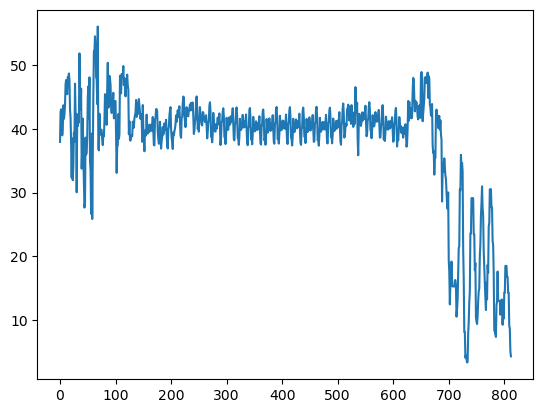

In [55]:
# plt.plot(totpers_d['AT1G69550.1'])
# plt.plot(totpers_d['AT3G44480.1'])

In [17]:

if False:
    from matplotlib.collections import LineCollection

    cutoff_d = {}

    for tairid, swtp in totpers_d.items():
        # g = gaussian_filter1d(swtp, 15)
        # if tairid !=  'AT5G44510.1':
        #     continue
        g = swtp

        # g = g-np.min(g)
        # g = g/np.quantile(g, .95)

        N= g.shape[0]

        mins = []
        argmins = []
        conf = np.array(get_conf(tairid)[:N])

        A = np.array([np.sum((g[:t] - np.sum(g[:t]) / np.max([1, t])) ** 2) + 0.5 * np.sum(g[t:] ** 2) for t in range(len(g))])
        t = np.argmin(A)

        cutoff_d[tairid] = t

        if False:
            myrect = (np.sum(g[:t]) / np.max([1, t])) * np.array([int(i < t) for i in range(len(g))])



            # for h in range(int(np.max(g))):
            #     def f(x):
            #         return np.sum(np.array([(g[ii] - h) if ii < x else g[ii]/2 for ii in range(N)])**2)
            #     res = minimize_scalar(f, bounds = (0, N), method='bounded')
            #     mins.append(res.fun)
            #     argmins.append(int(res.x))

            # h = np.argmin(mins)
            # b = argmins[h]
            # print(h,b)

            x = np.arange(N)
            y = g
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            
            
            fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)
            norm = plt.Normalize(conf.min(), conf.max())
            lc = LineCollection(segments, cmap='viridis', norm=norm)
            # Set the values used for colormapping
            lc.set_array(conf)
            lc.set_linewidth(2)
            line = axs.add_collection(lc)
            fig.colorbar(line, ax=axs)    

            # plt.plot(g)
            plt.plot(myrect)
            # plt.axhline(h, color = 'r')
            # plt.axvline(b, color = 'r')

            plt.savefig(make_path('plots','swtp_myrect', '%s.png'%tairid))
            plt.close()


In [12]:
# with open('pickles/cutoff_d.pickle', 'wb') as handle:
#     pickle.dump(cutoff_d, handle)    

In [21]:
def estimate_coil_hmm(v1, v2, pcc=0.99, phh=0.99, muh=0, muc=0.7, sigma=0.3):

    ## Step 1: compute radius and max-normalize to [0, 1]
    r = np.sqrt(v1**2 + v2**2)
    r = r/np.max(r)
    
    ## Step 2: Setup transition probabilities for HMM
    # States: 0 - In hairpin
    #         1 - Not in hairpin
    ptrans = [[phh, 1-phh],
             [1-pcc, pcc]]
    ptrans = np.log(np.array(ptrans))


    ## Step 3: Viterbi algorithm
    r = np.concatenate(([0], r))
    N = len(r)
    P = np.zeros((2, N)) # Accumulated log probability matrix
    T = np.zeros((2, N), dtype=int) # Transition matrix

    for j in range(1, N):
        # Hairpin observation probability
        o1 = -(r[j]-muh)**2/(2*sigma**2)
        # Coil observation probability
        o2 = -(r[j]-muc)**2/(2*sigma**2)
        obs = [o1, o2]
        for i in range(2):
            ps = [0, 0]
            for k in range(2):
                ps[k] = P[k, j-1] + ptrans[k, i] + obs[i]
            T[i, j] = np.argmax(ps)
            P[i, j] = ps[T[i, j]]

    ## Backtracing
    i = 1
    states = [i]
    j = N-1
    while j > 0:
        i = T[i, j]
        states.append(i)
        j -= 1
    states.reverse()
    states = states[1::]
    return states


def get_hairpins(coil_est):
    hairpins = []
    N = len(coil_est)
    i1 = 0
    in_hairpin = coil_est[0] == 0
    for i in range(1, N):
        if in_hairpin and coil_est[i] == 1:
            hairpins.append([i1, i])
            in_hairpin = False
        elif not in_hairpin and coil_est[i] == 0:
            i1 = i
            in_hairpin = True
    return hairpins

In [19]:
motifs_shifted_d = {}
for k, v in motifs_d.items():
    LRRstart = LRR_hmm_d[k]
    motifs_shifted_d[k] = [num-LRRstart for num in v]

In [20]:
for tairid in uniprot_d.keys():
    period = avgper(motifs_shifted_d[tairid])

    X = get_LRR_curve(tairid)
    # X = X[:cutoff_d[tairid]]
    X = get_curv_vectors(X, MaxOrder=1, sigma=1)[1]
    # np.save(make_path('npy', 'nlrome_X', '%s.npy'%tairid), X)
            
    #print out the number of residues in the chain, and print the locations of the LRR motif residues

    D = get_csm(X, X)
    # Clean up the matrix a bit by doing a sliding window of length roughly the period
    D = sliding_window(D, period)
    # Clean up the matrix even more by binarizing it with nearest neighbors
    B = csm_to_binary_mutual(D, 50)
    #B = B[0:400, 0:400]
    v = getUnweightedLaplacianEigsDense(1-B)

    if True:
        plt.figure(figsize=(18, 6))
        plt.subplot(131)
        plt.imshow(D, cmap='magma_r')
        plt.title("Self-Similarity Matrix")
        plt.subplot(132)
        plt.imshow(B)
        plt.title("Binarized Self-Similarity Matrix")
        plt.subplot(133)
        plt.imshow(v[:, 0:29], aspect='auto', cmap='magma_r', interpolation='none')
        for ii in motifs_shifted_d[tairid]:
            if ii in range(v.shape[0]):
                plt.axhline(ii)
        plt.title("Eigenvectors of Unweighted Graph Laplacian")
        plt.savefig(make_path('plots','eigenmatrix_nlrome_post', '%s.png'%tairid))
        plt.close()

    # np.save('npy/eigenmatrix_nlrome/%s.npy'%tairid, v)
    

In [32]:
len(set(matches_d.values()))

127

In [29]:
#generate eigenvector plots
for tairid in matches_d.keys():
    motifs_l = motifs_shifted_d[tairid]
    period = avgper(motifs_shifted_d[tairid])

    # if tairid!='AT4G27190.1':
        # continue
    for eig1, eig2 in [(0,1)]:
        v = np.load('npy/eigenmatrix_nlrome/%s.npy'%tairid)

        # plt.figure(figsize=(12, 4))
        s = v[:,eig1]
        c = v[:,eig2]

        # plt.show()
        # Detrend with daps
        sf = detrend_timeseries(s, period)
        cf = detrend_timeseries(c, period)

    # fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    # ax1.plot(s, color='blue')
    # ax1.plot(c, color='orange')
    # ax2.plot(s**2+c**2, color='red')
    # plt.subplots_adjust(hspace=0.4)

    r = np.sqrt(s**2+c**2)
    r = r/np.max(r)
    coil_est = estimate_coil_hmm(s, c)
    print(get_hairpins(coil_est))


    plt.figure(figsize=(12, 6))
    plt.subplot(311)
    plt.plot(s)
    plt.plot(c)
    plt.title("Eigenvectors")
    plt.subplot(312)
    plt.plot(r)
    plt.title("Normalized radius")
    plt.subplot(313)
    plt.plot(coil_est)
    plt.title("Coil Estimate")
    plt.tight_layout()    
    # plt.title(f"Eigenvectors 0 and 1 for {tairid}")

    # plt.show()

    plt.savefig(make_path('plots','hairpin_nlrome', '%s.png'%tairid))
    
    plt.close()

[[0, 18], [50, 62], [205, 250]]
[]
[[0, 19]]
[]
[[108, 124]]
[[0, 77]]
[[0, 10], [219, 273]]
[[0, 10], [137, 152]]
[[0, 13]]
[]
[[0, 68], [378, 418]]
[[0, 14], [47, 67], [333, 354]]
[[220, 250], [279, 296]]
[[0, 76], [325, 350]]
[]
[[230, 239], [286, 294]]
[[0, 26], [68, 93], [318, 355]]
[]
[[0, 7]]
[[0, 15]]
[[0, 110], [209, 245], [474, 1073], [1117, 1138]]
[]
[[0, 24]]
[[0, 23], [206, 254]]
[[0, 102]]
[[276, 285]]
[[0, 51], [343, 369]]
[[40, 59], [241, 255]]
[[0, 48], [278, 308], [381, 438]]
[[44, 64]]
[]
[[0, 24]]
[[287, 294]]
[[0, 13]]
[[223, 261], [283, 301]]
[[42, 68]]
[[0, 70], [91, 111], [378, 400]]
[[0, 51], [87, 104]]
[[0, 49], [91, 108]]
[[219, 240]]
[[217, 241], [285, 293]]
[[0, 19], [53, 77]]
[[0, 5]]
[[0, 20], [56, 82], [304, 335]]
[[0, 47], [82, 99], [362, 385]]
[[0, 87]]
[[0, 5]]
[[0, 70], [215, 229], [316, 330]]
[[0, 10], [255, 262], [399, 432]]
[[0, 76], [325, 350]]
[[223, 257], [288, 303]]
[[0, 20]]
[[0, 5]]
[[0, 7], [249, 257], [394, 419]]
[[280, 287]]
[[0, 29]]
[[0

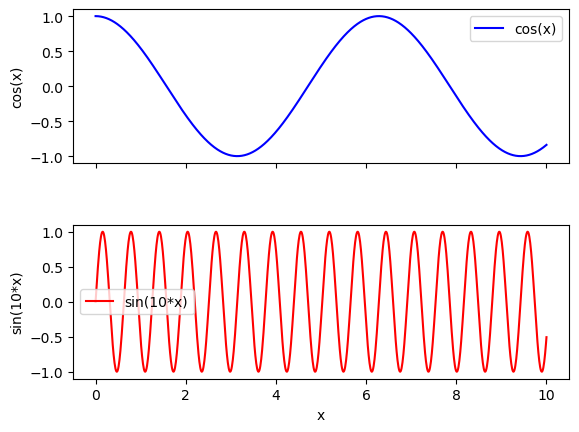

In [25]:
x = np.linspace(0, 10, 1000)

# Calculate y values for cos(x) and sin(10*x)
y_cos = np.cos(x)
y_sin = np.sin(10 * x)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot cos(x) on the top subplot
ax1.plot(x, y_cos, color='blue', label='cos(x)')
ax1.set_ylabel('cos(x)')

# Plot sin(10*x) on the bottom subplot
ax2.plot(x, y_sin, color='red', label='sin(10*x)')
ax2.set_xlabel('x')
ax2.set_ylabel('sin(10*x)')

# Add a legend to each subplot
ax1.legend()
ax2.legend()

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

# Show the plot
plt.show()

In [20]:
#generate phase estimation plots
for tairid in matches_d.keys():
    motifs_l = motifs_shifted_d[tairid]
    period = avgper(motifs_shifted_d[tairid])
    
    plt.figure(figsize = (12,6))
    for eig1, eig2 in [(0,1)]:
        v = np.load('npy/eigenmatrix_nlrome/%s.npy'%tairid)

        # plt.figure(figsize=(12, 4))
        s = v[:,eig1]
        c = v[:, eig2]
        # plt.plot(s)
        # plt.plot(c)
        # plt.show()
        # Detrend with daps
        sf = detrend_timeseries(s, period)
        cf = detrend_timeseries(c, period)

        # plt.figure(figsize=(12, 6))
        # plt.subplot(121)
        # plt.plot(sf)
        # plt.plot(cf)
        # plt.title("Detrended")
        # plt.subplot(122)
        # plt.title("Detrended Joint Plot")
        # plt.plot(sf, cf)
        # plt.show()

        # Extract the final phase and plot

        theta = np.arctan2(cf, sf)
        # plt.figure(figsize=(12, 4))
        plt.plot(theta, label=f'{eig1}, {eig2}')

        phases = []
        for res in motifs_l:
            if res in range(len(theta)):
                plt.plot(res, theta[res], 'bo')
                phases.append(theta[res])

    plt.title(f"Estimated phase for {tairid}")
    plt.legend()
    plt.xlabel("Residue Number")

#         np.save(make_path('npy','validation_phase', '%s.npy'%code), phases)
#         np.save(make_path('npy','validation_theta', '%s.npy'%code), theta)
#         np.save(make_path('npy','validation_plotted_motifs', '%s.npy'%code), np.array(plotted_motifs))
        # print(plotted_motifs, ommitted)

    # plt.show()

    plt.savefig(make_path('plots','nlrome_eigplot', '%s.png'%tairid))
    plt.close()

[0.40024460751230256, 1.4318551162293751, 1.4279632125025052, 1.4351090230263637, 1.4640401275920376, 1.6886124119177461, 1.8114496523105774, -0.655434058213594, 1.814754125170679, 1.873734525057455, 2.141368892800189, 1.9291022655950785, 1.8751644236986715]
[0.8328589052921829, 1.3428989991477631, 0.9190474478831316, 0.7210604797539404, 0.6721709389044983, 0.5371499891711519, 0.1693088923097655, 0.3666757127127906, 0.5635473481118926, 0.09716572261969866, 0.2980022495162292, 0.3922077606557642]
[-0.661575010070328, 0.2769948911275658, 0.26429304801259934, 0.27537843858031896, 0.2761567449815455, 0.34239866684845527, 0.510550156764166, 0.48863635754643076, 0.8185793117434027, 0.35651220676518386, 0.4099023486280924, 0.3052354913832194, -2.854828305174203]
[0.15288976883110078, 0.4128646166619752, 0.32046100642845016, 0.17963182406088546, 0.20892077470396475, 0.3681288943832709, 0.0383372696939273, -0.10434771650160536, -0.20326115999170657, -0.2824133475167909, 0.05629641742055943, -0.

In [10]:
motifs_l

[54, 84, 106, 129, 152, 175, 196, 237, 261, 284, 305, 325, 347]

In [18]:
cutoff_d[tairid]

370

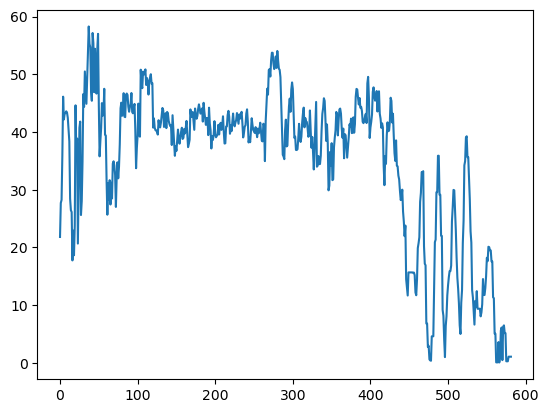

In [11]:
plt.plot(x, y)

0 247


FileNotFoundError: [Errno 2] No such file or directory: 'swtp/AT5G45050.1.png'

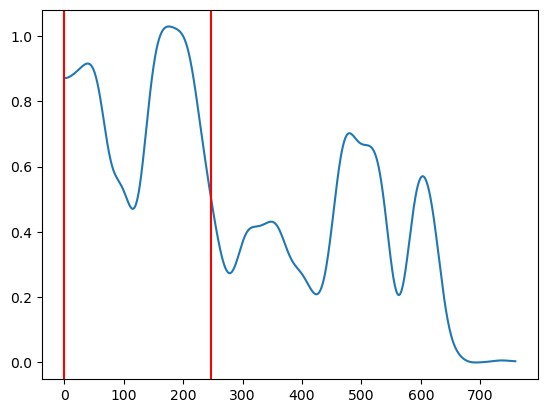

In [40]:
g = gaussian_filter1d(swtp, 15)
g = g-np.min(g)

g = g/np.quantile(g, .95)
N= g.shape[0]

mins = []
argmins = []
for a in range(int(.2*N)):
    def f(x):
        return np.sum(np.array([g[ii] - 1 if a < ii < x else g[ii] for ii in range(N)])**2)
    res = minimize_scalar(f, bounds = (a, N), method='bounded')
    mins.append(res.fun)
    argmins.append(int(res.x))

a = np.argmin(mins)
b = argmins[a]
print(a,b)

plt.plot(g)
plt.axvline(a, color = 'r')
plt.axvline(b, color = 'r')
plt.savefig(make_path('plots','swtp', '%s.png'%tairid))
plt.close()

In [37]:
argmins

[671,
 671,
 671,
 671,
 671,
 671,
 671,
 670,
 670,
 670,
 671,
 671,
 670,
 670,
 670,
 671,
 671,
 671,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 671,
 671,
 670,
 670,
 671,
 670,
 671,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 670,
 670,
 670,
 671,
 671,
 670,
 671,
 671,
 671,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 684,
 671,
 670,
 685,
 671,
 671,
 670,
 670,
 671,
 670,
 670,
 671,
 671,
 670,
 671,
 671,
 670,
 670,
 670,
 670,
 671,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 672,
 671,
 671,
 671,
 672,
 671,
 671,
 671,
 670,
 693,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 670,
 671,
 671]

0 671


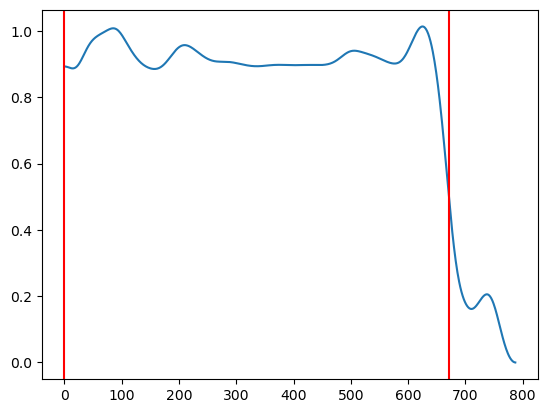

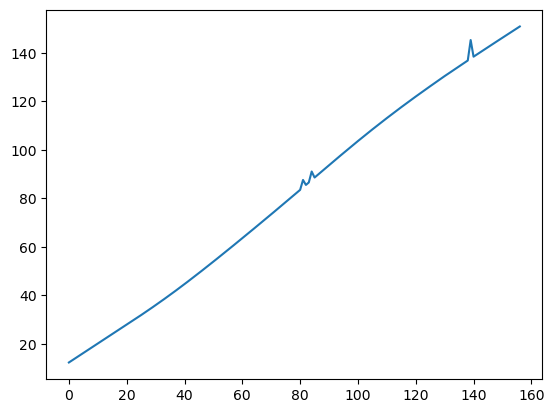

In [35]:
plt.plot(mins)

[400.00000881]


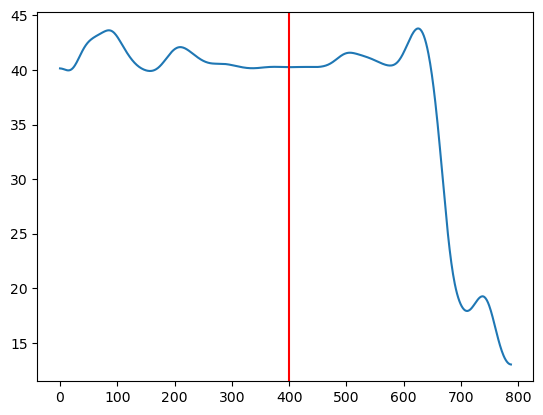

In [11]:
from scipy.optimize import minimize

swtp = gaussian_filter1d(totpers_d['AT1G69550.1'], 15)

def f(x):
    return np.sum(np.array([swtp[ii] - 40 if ii<x[0] else swtp[ii] for ii in range(swtp.shape[0])])**2)

res_1 = minimize(f, [400], bounds = [(0, len(swtp))])

a = res_1.x[0]
print(res_1.x)
plt.plot(swtp)
plt.axvline(a, color = 'r')

In [54]:
def f(x):
    return np.sum(np.array([swtp[ii] - 40 if ii<x else swtp[ii] for ii in range(swtp.shape[0])])**2)

res = minimize_scalar(f, bounds = (0, len(swtp)), method='bounded')

     fun: 48098.04667267787
 message: 'Solution found.'
    nfev: 28
     nit: 28
  status: 0
 success: True
       x: 675.5420087357162

In [38]:
f(400)

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

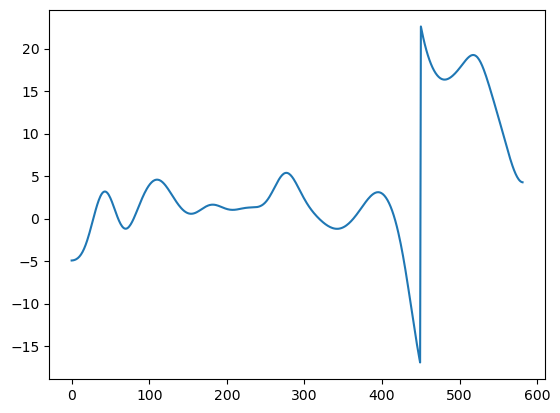

In [31]:
plt.plot(f([450]))

array([150.00000908,  40.95152643])

In [71]:
f([0, 450, 40])

[-4.925948949596467,
 -4.919270893073801,
 -4.90556810527589,
 -4.884575160531554,
 -4.855585046199721,
 -4.81797237659022,
 -4.770831506008982,
 -4.713187927518959,
 -4.64393230318916,
 -4.561991051209205,
 -4.466330626705606,
 -4.35587104015503,
 -4.229498366356154,
 -4.086183818455289,
 -3.9252591356731017,
 -3.746158609631941,
 -3.5483905946213383,
 -3.33193123979526,
 -3.096839849238876,
 -2.8435010231064837,
 -2.572811814979133,
 -2.2858641986536483,
 -1.9839840073170194,
 -1.6689713764529728,
 -1.342779395441596,
 -1.0077150108667325,
 -0.6663988881211509,
 -0.3217087970281014,
 0.02333514134971182,
 0.36564368566891403,
 0.7019012464210874,
 1.0288990953081694,
 1.343296353905572,
 1.6417753933719226,
 1.921108833454653,
 2.1785059991966875,
 2.4112934790433442,
 2.616965772071879,
 2.793147655563459,
 2.9383133380041784,
 3.0509828687300313,
 3.1304324330441915,
 3.1759010897321645,
 3.18727025108209,
 3.1650906595019066,
 3.109987028146058,
 3.0233049800198657,
 2.90674585703

In [36]:
np.save('npy/totpers_%s.npy'%tairid, totpers_l)

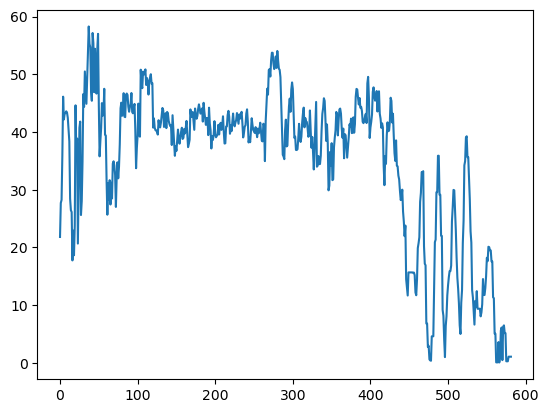

In [35]:
plt.plot(totpers_l)

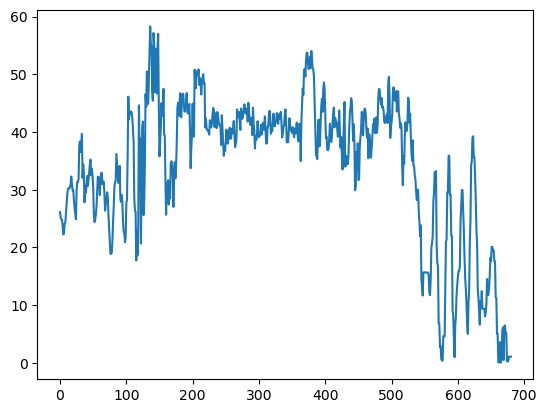

In [58]:
plt.plot(totpers_l)